# Solutions for Beer Predictions


In [1]:
%autosave 0

Autosave disabled


In [2]:
%matplotlib inline
import string
from  collections import Counter
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sbn
from altair import Chart, X, Y, Color, Scale
import altair as alt
import requests
import nltk
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from graphviz import Digraph

matplotlib.style.use('ggplot')


In [388]:
c = Counter()
_ = bf[bf['review/overall'] < 3.5].text_list.map(lambda x  : c.update([y for y in x if y not in sw]))
bad_beer_words = set([w[0] for w in c.most_common(200)])

In [389]:
c = Counter()
_ = bf[bf['review/overall'] >= 3.5].text_list.map(lambda x  : c.update([y for y in x if y not in sw]))
good_beer_words = set([w[0] for w in c.most_common(200)])

In [390]:
bad_beer_words - good_beer_words

{'3',
 'actually',
 'average',
 'brewery',
 'bubbles',
 'carbonated',
 'cherry',
 'else',
 'expected',
 'faint',
 'go',
 'going',
 'gold',
 'got',
 'grain',
 'grainy',
 'hard',
 'honey',
 'interesting',
 'kind',
 'lager',
 'looking',
 'looks',
 'metallic',
 'ok',
 'probably',
 'rather',
 'say',
 'seems',
 'somewhat',
 'sour',
 'watery',
 'weak',
 'wheat',
 'yeast',
 'yellow'}

In [423]:
#my_bb_words = ['horrible', 'terrible', 'bad', 'nasty', 'gross', 'average', 'carbonated', 'interesting', 'cherry', 'faint', 'grain', 'metallic', 'watery', 'sour', 'weak', 'wheat', 'yeast', 'yellow']
manual_bb_words = set(['horrible', 'terrible', 'nasty', 'gross', 'bad'])
my_bb_words = list(bad_beer_words - good_beer_words | manual_bb_words)

In [392]:
good_beer_words - bad_beer_words

{'4',
 'balanced',
 'burnt',
 'colored',
 'come',
 'complex',
 'earthy',
 'easy',
 'excellent',
 'finishes',
 'founders',
 'fresh',
 'grapefruit',
 'huge',
 'love',
 'makes',
 'nicely',
 'oak',
 'perfect',
 'pine',
 'porter',
 'presence',
 'present',
 'rich',
 'rye',
 'side',
 'sip',
 'smoked',
 'solid',
 'spicy',
 'sticky',
 'sugar',
 'tasty',
 'thanks',
 'toffee',
 'tongue'}

In [425]:
#my_gb_words = ['great', 'awesome', 'good', 'toffee', 'amazing', 'spicy', 'smoked', 'rye', 'perfect', 'oak', 'fresh', 'excellent', 'complex', 'earthy', 'balanced', 'easy']
manual_gb_words = set(['great', 'awesome', 'perfect', 'amazing', 'wonderful'])
my_gb_words = list(good_beer_words - bad_beer_words | manual_gb_words)

In [426]:
for word in my_bb_words:
    bf[word] = bf.text_list.map(lambda x : 1 if word in x else 0)
    

In [427]:
for word in my_gb_words:
    bf[word] = bf.text_list.map(lambda x : 1 if word in x else 0)


In [428]:
bf.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate',
       ...
       'smoked', 'nasty', 'gross', 'bad', 'terrible', 'horrible', 'awesome',
       'amazing', 'wonderful', 'great'],
      dtype='object', length=102)

In [429]:
beer_X = bf[my_bb_words + my_gb_words + ['beer/ABV']]
beer_y = bf[['thumbs']]
train_X, test_X, train_y, test_y = train_test_split(beer_X, beer_y, random_state=42)

In [430]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
#rmodel = LogisticRegression(solver='lbfgs')
rmodel = LinearRegression()
rmodel.fit(train_X.values, train_y.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [431]:
preds = rmodel.predict(test_X)

In [432]:
abs(preds-test_y.values).mean()

0.27171860056966407

In [433]:
#accuracy_score(test_y, preds)

In [434]:
#np.sqrt(((preds-test_y) ** 2.0).mean())

In [435]:
sorted_weights = sorted(list(zip(beer_X.columns.tolist(), rmodel.coef_.ravel().tolist())), key=lambda x : x[1], reverse=True)
sorted_weights

[('easy', 0.09897475529700242),
 ('solid', 0.08193606042382606),
 ('tasty', 0.07926292696423745),
 ('perfect', 0.07429735785293201),
 ('excellent', 0.06874988526786646),
 ('awesome', 0.06233364191142189),
 ('balanced', 0.06045033839990843),
 ('wonderful', 0.05799172999897152),
 ('great', 0.05636937453118318),
 ('amazing', 0.05219272230869499),
 ('nicely', 0.04952653333618656),
 ('rich', 0.04942543734985559),
 ('rye', 0.04756608986925993),
 ('grapefruit', 0.047352162098180085),
 ('porter', 0.0412026680923209),
 ('complex', 0.04118874233301322),
 ('earthy', 0.03727280299704358),
 ('fresh', 0.03382554365023634),
 ('smoked', 0.032029959306983415),
 ('love', 0.030006154158548782),
 ('finishes', 0.026359252408330078),
 ('spicy', 0.024980833928766023),
 ('side', 0.021876927774935412),
 ('4', 0.02125435494723614),
 ('toffee', 0.02027943735216922),
 ('oak', 0.018260588038089724),
 ('tongue', 0.017796144294097545),
 ('pine', 0.014721932044263076),
 ('colored', 0.01353474137965632),
 ('thanks', 0

Lets see if we can visualize this 

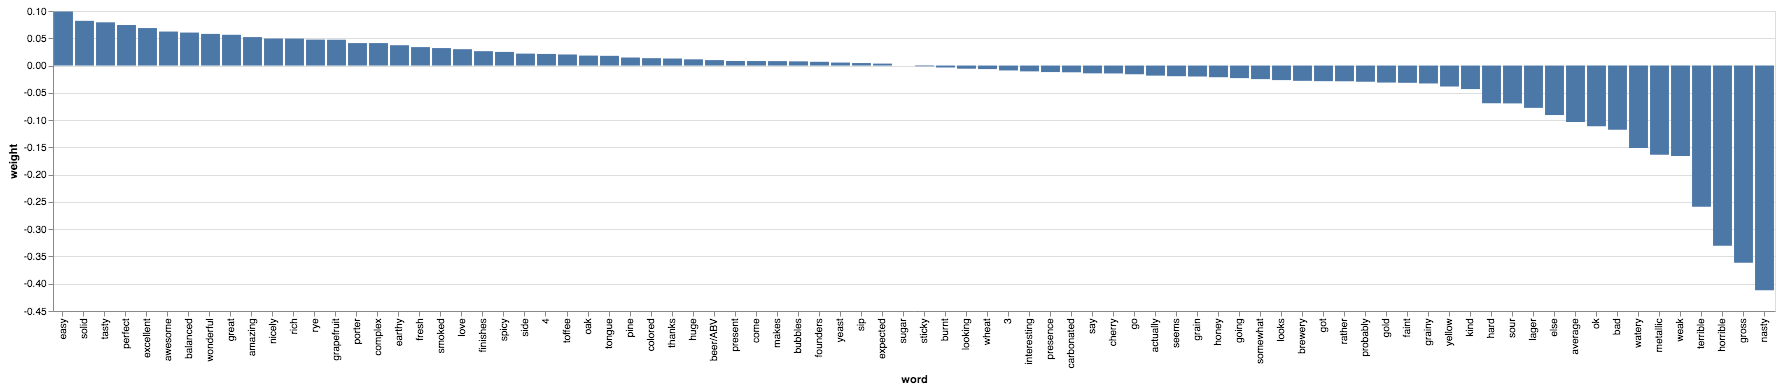

In [436]:

alt.Chart(pd.DataFrame([{'word': x[0], 'weight': x[1]} for x in sorted_weights])).mark_bar().encode(alt.X('word:N', sort=alt.EncodingSortField(field='weight:Q', op='values', order='ascending')),
                                                                                                    y='weight:Q')



If you look at it, its pretty interesting to see the two ends of the graph.  Look at the words that have the highest positive weights.  Who knew that 'grapefruit' was such a desireable characteristic of a beer!?

The question you may be asking yourself is "How does this work exactly?"   Lets take an example and work through it step by step using the weights above.

Here's an example of a review with a solid 5 rating.

In [419]:
pd.set_option('display.max_colwidth', 100)
bf.loc[12]

index                                                                                                              32481
beer/ABV                                                                                                            11.2
beer/beerId                                                                                                        19960
beer/brewerId                                                                                                       1199
beer/name                                                                        Founders KBS (Kentucky Breakfast Stout)
beer/style                                                                              American Double / Imperial Stout
review/appearance                                                                                                    4.5
review/aroma                                                                                                         4.5
review/overall                  

Now lets do the math.


In [437]:
set(bf.loc[12, 'text_list']) & (set(my_gb_words)  - set(my_bb_words))

{'founders', 'great'}

In [439]:
weight_d = dict(sorted_weights)
score = 0
for w in bf.loc[12, 'text_list']:
    weight = weight_d.get(w,0)
    if weight > 0:
        print(w, weight)
        score += weight * bf.loc[12, w]
    
print(score)

founders 0.006847636797134196
great 0.05636937453118318
0.06321701132831738


Even with a great beer we are not always going to hit the words.

## Sentiment Analysis with Python's Natural Language Toolkit (NLTK)

So, our simple approach to using words from the review is not too bad.